---
---
# **Phase 1: Baseline Model & Loss Functions**
*IS53051A/IS71071B: MACHINE LEARNING*

by Augusta Lina

---


<center>
  <figure>
    <img src="https://i.imgur.com/T98ul4U.png" >
   </figcaption>
  </figure>
</center>

---
---
# Introduction
---

The purpose of Phase 1 is to build a simple, baseline model which underfits the data and to determine the best loss function to use when modelling. In this research we build a simple 2D convolutional neural network (CNN) and test four loss functions: categorical cross-entrophy, DICE Loss, a combined loss with a 50-50 ratio and a DICE loss with a small categorical cross-entrophy penalty added to the loss. This is visualised in the figure below. The results showed that the DICE loss with the penalty term performed best so this loss function was used in Phases 2 and 3.

<center>
  <figure>
    <img src="https://i.imgur.com/ygGoJTs.png" >
   </figcaption>
  </figure>
</center>

The results of Phase 1 are shown in the bar charts below. The first chart shows the DICE scores across each segmentation label for each loss function. These represent the amount of overlap between the predicted mask and the human-annotated segmentation mask. The second chart shows the macro multi-class classification metrics for each loss function. The DICE scores and classification accuracy metrics shown are calculated excluding the model's performance when predicting the background. This is because the background consists of not only the image background but also the healthy brain tissue. The background is not only the majority class by a significant margin, it is also the class we are not interested in predicting. We can see that the combined weighted loss function, the DICE loss with a penalty term, performed best across all metrics except for macro precision which had an inverse relationship with the other metrics.

<center>
  <figure>
    <img src="https://i.imgur.com/CBKMpBK.png" >
   </figcaption>
  </figure>
</center>

---
---
# Convolutional Neural Networks
---

---
---
# Set Up Environment
---

We mount Google Drive and change the working directory.

In [ ]:
# Import libraries
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Change working directory & Confirm
WORKING_DIR = '/content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory'
os.chdir(WORKING_DIR)
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory


---
### Load Libraries
---

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

Set random seeds.

In [ ]:
np.random.seed(202)
tf.random.set_seed(202)
random.seed(202)

---
---
# Load Data
---

We load the train and validation sets from the `.npz` files saved during the data preprocessing step. Our targets and features are:

- `X`: preprocessed 2D MRI slices
- `Y`: one-hot encoded segmentation masks

The segmentation masks were already label-remapped and one-hot encoded in preprocessing, so we can use them directly for training.


In [ ]:
saveFolder = os.path.join(WORKING_DIR, "Processed2DData")

In [ ]:
# Load .npz files
trainData = np.load(os.path.join(saveFolder, "train.npz"))
valData = np.load(os.path.join(saveFolder, "val.npz"))

In [ ]:
# Extract arrays: Train
XTrain = trainData['X']
YTrainCat = trainData['Y']

In [ ]:
# Extract arrays: Validation
XVal = valData['X']
YValCat = valData['Y']

In [ ]:
# Confirm load
print(f"Training set: {XTrain.shape}")
print(f"Validation set: {XVal.shape}")

Training set: (1287, 128, 128, 3)
Validation set: (277, 128, 128, 3)


---
---
# Baseline Model
---

---
### Convolutional Neural Network
---
A convolutional neural network (CNN) is a neural network designed to capture spatial relationships within grid-like data. For this reason, it is particularly well suited to image-based tasks such as image segmentation.

**Convolutional Layers**

The core mechanism within a CNN is the convolutional layer. These layers apply a set of learnable filters, kernels, which slide across the grid in a specified step size, performing an operation called a convolution. Each filter detects specific features like edges or corners. As the filter slides over the input, it produces a feature map.

Mathematically, the dot product of the kernel weights and the kernel's local receptive field for each channel is summed, and a bias is added to get a resulting scalar value that is added to the feature map of that convolution layer. This kernel then slides along the image in a specified stride, and this operation is performed again until the kernel has moved across the entire image, and the resulting feature map is extracted. Once a feature map has been created, this matrix is then fed into an activation function. A single convolution operation can be summarised as:

$$
\mathrm{ReLU}\bigl( X \cdot K + \text{bias} \bigr)
$$


Where $X$ is the input tensor of shape ($H \times W \times C_\text{in}$) and $K$ is the kernel of shape ($K_H \times K_W \times C_\text{in}$). $ C_{\text{in}} $ is the number of input channels. The activation function $\mathrm{ReLU}(x) = \max(0, x)$ introduces non-linearity. This process produces one feature map per kernel. The number of feature maps of the previous layer becomes the number of channels in the next layer.

**Max Pooling Layers**

Max pooling layers follow convolutional layers to downsample feature maps. They slide a window over each feature map and retain the maximum value within that window. Pooling layers do not learn any parameters. Instead, they perform a fixed downsampling operation. This process is used to help the model focus on more important features.

**Architecture**

An encoder-decoder architecture with a bottleneck is often used for image segmentation tasks. This structure downsamples the image, then teaches the network to upsample the image.

The encoder portion progressively downsamples the image using convolutions and max pooling, increasing the number of kernels at each layer. This process helps the model learn contextual information and abstract features.

The decoder progressively upsamples the feature representation back to the original image size using upsampling and convolutions. One strength of kernels is that they learn features regardless of where they are in the image. This makes CNNs flexible at understanding images. However, during segmentation, understanding the local position of certain features is important. The intention of the decoder portion is to localise the learned features to specific areas in the model and reconstruct a detailed segmentation map.

The final layer of an encoder-decoder CNN is a 1x1 convolution with a softmax activation function that produces a pixel-wise classification map. For each pixel in the image, it outputs the probability of that pixel belonging to each of the classes. The softmax activation function is used to turn the raw output of the model into a probability distribution that sums to 1. It is given by:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$$

Where $z$ is the input vector to the softmax layer, $C$ is the number of classes, $z_i$ is the input to the $i^{\text{th}}$ class and $\text{softmax}(z_i)$ is the probability assigned to class $i$.

---
### Define & Compile Model
---

---
### Define Baseline CNN
---

We define a baseline CNN model using a custom function `baseCNN()` which will be used for building the model for each of the four rounds in this phase. The below model is a simple encoder–decoder CNN. The ecoder consists of two convolutional layers of increasing filter numbers (32, 64), a bottleneck layer of 128 kernels, and two max pooling layers which both reduce the spatial resolution by a factor of two.

The decoder consists of two upsampling layers which each double the resolution and two convolutional layers of decreasing kernel counts (64, 32). The model receives inputs of shape `(128, 128, 3)` corresponding to the three 128 x 128 MRI image modalities, FLAIR, T1CE and T2, for each instance. The final layer is a 1x1 convolutional layer with a softmax activation function which produces a probability map for each of the 4 classes for each pixel in a 128 x 128 frame.

In [ ]:
def baseCNN(inputShape=(128, 128, 3), numClasses=4):
    inputs = layers.Input(shape=inputShape)
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Bottleneck
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    # Output
    outputs = layers.Conv2D(numClasses, (1, 1), activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

---
---
# Define Evaluation Functions
----

In this section we define functions to plot the training logs, calculate the DICE scores and the macro accuracy metrics.

---
### Custom Function to View Training Logs
---

We create a function to display the training logs for the validation loss and validation accuracy for each round. This helps us monitor the model's training for qualities such as plateaus, inconsistent training and overfitting. We suppress the training logs during training so the plots help us understand how the model is adjusting over consecutive epochs.



In [ ]:
def plotHist(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Loss
    axs[0].plot(history.history['loss'], label="Training Loss")
    axs[0].plot(history.history['val_loss'], label="Validation Loss")
    axs[0].set_title("Training vs Validation Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)
    # Accuracy
    axs[1].plot(history.history['accuracy'], label="Training Accuracy")
    axs[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[1].set_title("Training vs Validation Accuracy")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

---
### Custom DICE Score Function
---

DICE scores are standard scores used to measure performance during BraTS challenges and in segmentation tasks. They capture the overlap between the predicted and human-annotated masks.

The below function calculates the  per-class Dice scores for three tumour regions, necrotic core (1), edema (2) and enhancing tumour (3) and excludes the background (0). The scores for each class are calculates by:

$$
\text{DICE} = \frac{2 \cdot \text{TP}}{2 \cdot \text{TP} + \text{FP} + \text{FN}}
$$

The equation divides two times the number of true positive voxels by the sum of the total predicted positives (TP + FP) and the total actual predicted positives (TP+ FN). This results in a perfect score of one when the prediction matches the ground truth exactly and zero when it misses it entirely. The score reduces when we miss true positives or predict false positives. Each DICE score is between zero and one.

The results are stored in a summary table which the model returns. The returned tables will be used to tally the results of the rounds.



In [ ]:
def diceScore(yTrue, yPred, modelName="Name", smooth=1e-6):
    yTrueFlat = tf.cast(tf.reshape(yTrue, (-1, 4)), dtype=tf.float64)
    yPredFlat = tf.cast(tf.reshape(yPred, (-1, 4)), dtype=tf.float64)

    diceScores = []
    for c in range(1, 4):
        intersection = tf.reduce_sum(yTrueFlat[:, c] * yPredFlat[:, c])
        union = tf.reduce_sum(yTrueFlat[:, c]) + tf.reduce_sum(yPredFlat[:, c])
        dice = (2. * intersection + smooth) / (union + smooth)
        diceScores.append(dice.numpy())

    meanDice = np.mean(diceScores)

    summaryTable = pd.DataFrame({"Mean": [meanDice],"1 Necrotic Core": [diceScores[0]],
        "2 Edema": [diceScores[1]], "3 Enhancing Tumour": [diceScores[2]],}, index=[modelName])

    return summaryTable.round(4)

---
### Macro Accuracy Metrics
---

The below function calculates the macro averaged scores for Precision, Recall, the F1-Score and overall Accuracy for classes one through three, the areas with tumour tissue. The function calculates the metrics for each of the three classes and then takes the average of each metric to get the macro average. Precision measures the proportion of predicted positives for a class which are actually correct. It is calculated as:


$$
\text{Precision}_c = \frac{TP_c}{TP_c + FP_c}
$$

Where the *c* subscript indicates that we are working with values like true positives for a given class when calculating a metric and not the entire dataset. Recall measures the proportion of actual positives that are correctly predicted and is calculated as:

$$
\text{Recall}_c = \frac{TP_c}{TP_c + FN_c}
$$

The F1 Score is the harmonic mean of Precision and Recall. It is a measure which balances the model's ability to correctly predict the positive class and not misclassify the negative class. The F1 Score is calculated as:

$$
\text{F1}_c = \frac{2 \cdot \text{Precision}_c \cdot \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}
$$

We remove the background from the calculations because this mask frequently comprises over 90% of the MRI, as demonstrated when calculating the voxel volumes. This would artificially inflate the results, which would make it difficult to follow the progress of the model as the background scores would add noise to the figures. The function returns a table of the results which will be used to create a tally for Phase 1, as with the DICE Score function. At the end of Phase 1, the results of the tallys will be shown in a comparative bar chart.

In [ ]:
def classMets(yTrue, yPred, modelName="Name"):
    yTrueLabels = np.argmax(yTrue, axis=-1).flatten()
    yPredLabels = np.argmax(yPred, axis=-1).flatten()

    nonBackgroundMask = yTrueLabels > 0
    yTrueNB = yTrueLabels[nonBackgroundMask]
    yPredNB = yPredLabels[nonBackgroundMask]
    precision = precision_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    recall = recall_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    f1 = f1_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    accuracy = accuracy_score(yTrueNB, yPredNB)

    summaryTable = pd.DataFrame({"Macro Precision": [precision],
        "Macro Recall": [recall], "Macro F1": [f1],
        "Accuracy (No Background)": [accuracy]}, index=[modelName])

    return summaryTable.round(4)

---
---
# Categorical Cross-Entrophy
---

---
### Build & Compile
---

We compile the model using the the Adam optimiser with a learning rate of 1e-4 and Tensorflow's default categorical cross-entropy loss function.

**Categorical Cross-entropy Objective Function**

The categorical cross-entropy loss function is designed to measure how well a model's predicted probability distribution matches the actual distribution of the dataset. A single instance is calculated by:

  $$
  \text{Categorical Cross-entropy Loss} = -\sum_{i=1}^{C} y_i \log(p_i)
  $$

Where $C$ is the number of classes, and $y_i$ is the true class label. For each class label, which in our case is classes zero through three, the loss function multiplies the true class label, which is 1 for the true class and 0 for all others by the log of the model's predicted probability that the instance belongs to that class and sums the results. The effective result is the log of the probability the model predicted for the true class multiplied by -1.

**Adam Optimiser**

The Adam optimiser is an adaptive optimiser which combines the functionality of Momentum and RMSProp. Optimisers use the results of backpropagation to update the model's parameters during neural network training. Momentum maintains an exponentially decaying average of past gradients, which helps smooth out the update steps and accelerates the loss function's convergence. Similarly, RMSProp maintains an exponentially decaying average of past squared gradients which is used to adapt the learning rate for each parameter. This helps prevent against issues with vanishing or exploding gradients and is efficient because the learning rate adjustments are responsive rather than being adjusted manually.

In [ ]:
# Instantiate and compile model
baseModel = baseCNN()

baseModel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

The model structure can be displayed in a table using the `.summary()` method. In total it contains trainable 185, 636 parameters.

In [ ]:
# View model summary
baseModel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 4)    │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,636 (725.14 KB)

 Trainable params: 185,636 (725.14 KB)

 Non-trainable params: 0 (0.00 B)

---
### Train Model
---

We create a directory to save the model checkpoints. The checkpoint callback saves the best model, defined by the validation loss. The early stopping callback uses a patience of 10. It stops training after the model has stopped improving after 10 epochs and restores the best performing weights at the end of training.

In [ ]:
saveDir = os.path.join(WORKING_DIR, "saved_models_phase1")
os.makedirs(saveDir, exist_ok=True)

In [ ]:
# checkpoints
checkpoint = ModelCheckpoint(filepath=os.path.join(saveDir, "baseModel_best.h5"),
    monitor="val_loss", save_best_only=True, verbose=0)

# early stopping
earlyStopping = EarlyStopping(monitor="val_loss", patience=10,
    restore_best_weights=True, verbose=0)

We train the model using 50 epochs, a batch size of 16 and the callbacks defined above.

In [ ]:
# Train
baseHistory = baseModel.fit(x=XTrain,y=YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint, earlyStopping],
    verbose=0)

---
## Evaluation
---

The model was trained for all 50 epochs and plateaus fairly quickly without overfitting, indicating that the model is underfitting and could benefit from additional complexity and training for further epochs. We increase the model complexity in Phase 2 and train for more epochs in Phase 3 in order to keep the development process systematic.

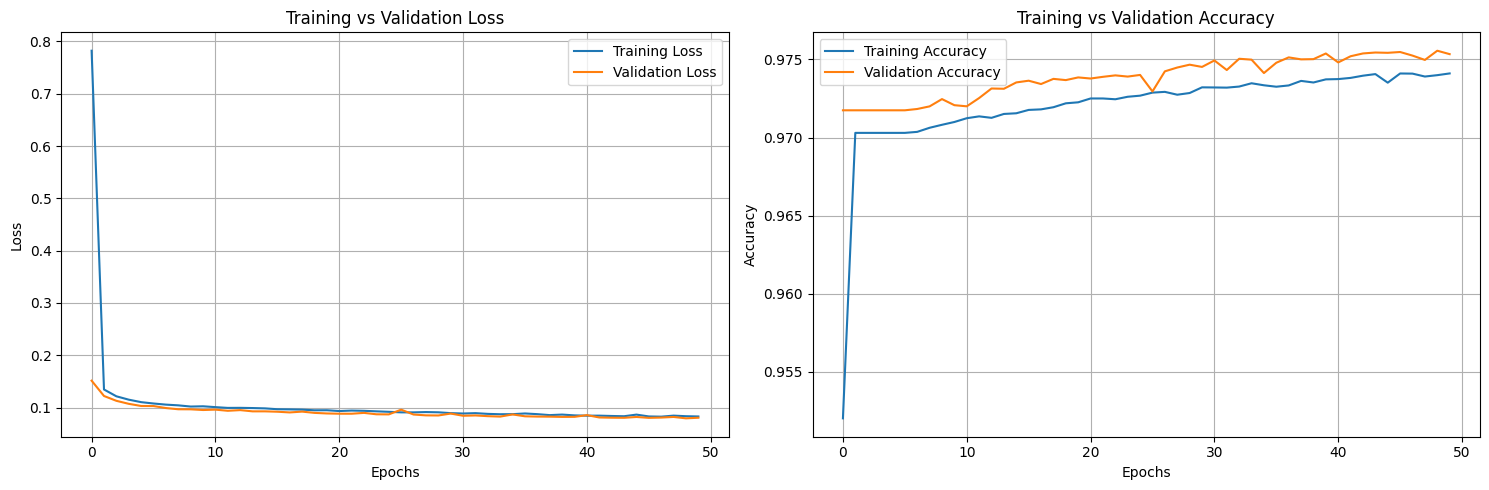

In [ ]:
plotHist(baseHistory)

In order to calculate the DICE scores and macro classification metrics we call the `predict()` method on the best performing model.

In [ ]:
# Predict on validation set
YValPred = baseModel.predict(XVal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


Next we call the functions to calculate the DICE scores and macro classification metrics wihch we defined earlier.

In [ ]:
# Compute Dice score
baseTable = diceScore(YValCat, YValPred, modelName="Base Model")

**Metric Interpretation**

The model demonstrates fairly poor performance. If we consider that there is a 25% probability of randomly selecting one of the four classes, the DICE scores show the model performs worse than random guessing. However, considering the model has a smooth clear training log and shows clear signs of underfitting, this problem can be easily remedied as we progress through the development phases.   

The macro precision is relatively high, 0.63, meaning that the model is often correct when it does make a prediction for a tumour class.

In [ ]:
print(baseTable)

              Mean   1 Necrotic Core  2 Edema  3 Enhancing Tumour
Base Model  0.1768            0.1429   0.2604               0.127


In [ ]:
baseMetrics = classMets(YValCat, YValPred, modelName="Base Model")

In [ ]:
print(baseMetrics)

            Macro Precision  Macro Recall  Macro F1  Accuracy (No Background)
Base Model           0.6318        0.1361    0.1684                    0.2224


---
## Visualising Predictions
---

As a qualitative comparative analysis we will plot the best and worst performing samples for this first baseline model and repeat the process with the final model at the end of Phase 3 to understand how the model has progressed.

By analysing the best and worst performing samples we can understand why the model performs well and the reasons it might struggle.

To do this, we convert the softmax probability mask, the model's output, into a one-hot encoded mask.

In [ ]:
def oneHotMask(maskSoftmax):
    classIndices = np.argmax(maskSoftmax, axis=-1)
    oneHotMask = np.eye(4)[classIndices]
    return oneHotMask

We calculare the mean DICE score for each sample in the dataset rather than across the entire dataset as we did when calculating the DICE scores. This allows us to select the best and worst performing samples.

In [ ]:
def sampleDice(yTrue, yPred, smooth=1e-6):
    scores = []
    for i in range(yTrue.shape[0]):
        diceList = []
        for c in range(1, 4):
            yt = yTrue[i, ..., c].flatten()
            yp = yPred[i, ..., c].flatten()
            intersection = np.sum(yt * yp)
            union = np.sum(yt) + np.sum(yp)
            dice = (2. * intersection + smooth) / (union + smooth)
            diceList.append(dice)
        scores.append((i, np.mean(diceList)))
    return scores

We create a semi-transpartent colour map for the segmentaion masks and greyscale the MRIs. This function allows us to plot the MRIs with the predicted and actual probability masks.

In [ ]:
def plotSample(mri, trueMask, predMask, title_prefix=""):
    colours = [(0, 0, 0, 0), (1, 0, 0, 0.6), (0, 1, 0, 0.6), (1, 1, 0, 0.6)]
    customCmap = ListedColormap(colours)

    fig, axs = plt.subplots(1, 3, figsize=(6, 3))
    axs[0].imshow(mri.T, cmap="gray", origin="lower")
    axs[0].set_title("MRI Slice", fontsize=10)
    axs[0].axis("off")

    axs[1].imshow(mri.T, cmap="gray", origin="lower")
    axs[1].imshow(trueMask.T, cmap=customCmap, origin="lower", alpha=0.5)
    axs[1].set_title("Ground Truth Overlay", fontsize=10)
    axs[1].axis("off")

    axs[2].imshow(mri.T, cmap="gray", origin="lower")
    axs[2].imshow(predMask.T, cmap=customCmap, origin="lower", alpha=0.5)
    axs[2].set_title("Prediction Overlay", fontsize=10)
    axs[2].axis("off")

    fig.suptitle(title_prefix, fontsize=10)
    plt.tight_layout()
    plt.show()

Not every MRI slice contains tumour regions, therefore we exclude samples which do not contain affected areas.

In [ ]:
validIndices = [i for i in range(YValCat.shape[0])
    if np.sum(np.argmax(YValCat[i], axis=-1) > 0) > 0]

We call the per sample DICE score function on the selected samples.

In [ ]:
diceScores = []
for i in validIndices:
    score = sampleDice(YValCat[i:i+1], YValPred[i:i+1])[0][1]
    diceScores.append((i, score))

Next, we filter the best and worst performing samples, defined by their DICE score.

In [ ]:
sortedScores = sorted(diceScores, key=lambda x: x[1])
worst = sortedScores[:2]
best = sortedScores[-2:]

It is very difficult to tell, but the worst case samples do contain segmentation masks, except that the tumour regions only consist of handful of pixels, which we cannot see with our eye clearly. Within this markdown is an image of the second worst performing sample which uses colour contrasts to make this easier to see.

<center>
  <figure>
    <img src="https://i.imgur.com/t0byGON.png", width=600 >
   </figcaption>
  </figure>
</center>

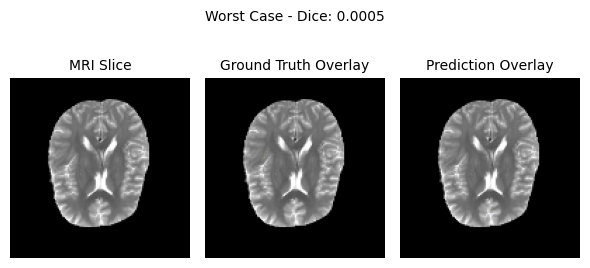

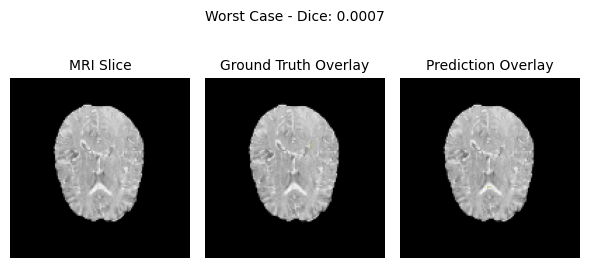

In [ ]:
for idx, score in worst:
    mri = XVal[idx]
    trueMask = np.argmax(YValCat[idx], axis=-1)
    predMask = np.argmax(YValPred[idx], axis=-1)
    if mri.ndim == 3 and mri.shape[-1] == 3:
        mri = np.mean(mri, axis=-1)
    plotSample(mri, trueMask, predMask, f"Worst Case - Dice: {score:.4f}")

The model seems to be accurately predicting the shape of the tumour region but struggles to predict individual segments within this region.

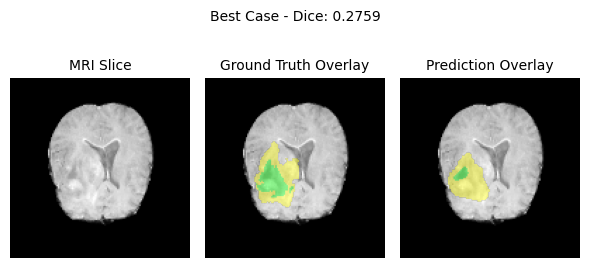

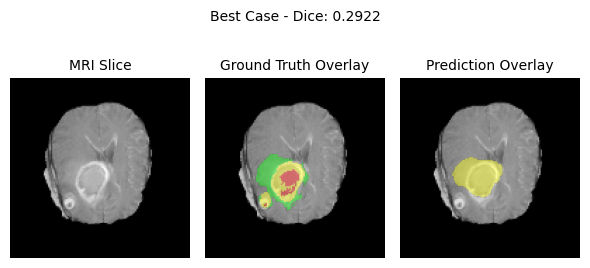

In [ ]:
for idx, score in best:
    mri = XVal[idx]
    trueMask = np.argmax(YValCat[idx], axis=-1)
    predMask = np.argmax(YValPred[idx], axis=-1)
    if mri.ndim == 3 and mri.shape[-1] == 3:
        mri = np.mean(mri, axis=-1)
    plotSample(mri, trueMask, predMask, f"Best Case - Dice: {score:.4f}")

---
---
# Simple CNN with DICE Loss
---

---
### Define & Compile Model
---

We create a custom DICE loss function which will be fed to the compiler and used to update the model's weights during training. The DICE Loss function calculates the DICE score for each class, which was described in the section *Custom DICE Score Function*. It then calculates 1 - DICE which becomes the loss for that class. This value is divided by three to get the average loss over the training sample.

The background is not included in the loss function in order to get the model to focus on learning the tumour segmentation masks rather than the background.

### Define Dice Loss

In [ ]:
def diceLoss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.reshape(y_true, (-1, 4))
    y_pred_f = K.reshape(y_pred, (-1, 4))

    loss = 0
    for c in range(1, 4):
        yt = y_true_f[:, c]
        yp = y_pred_f[:, c]
        intersection = K.sum(yt * yp)
        union = K.sum(yt) + K.sum(yp)
        dice = (2. * intersection + smooth) / (union + smooth)
        loss += 1 - dice

    return loss / 3

### Rebuild and Compile Model

We build and compile the baseline CNN model with the custom DICE Loss function and Tensorflow's default Accuracy metric using the Adam optimiser and a 1e-4 learning rate as before.

In [ ]:
diceModel = baseCNN()

In [ ]:
diceModel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=diceLoss,
    metrics=["accuracy"])

---
### Train Model
---

We fit the model with the standard parameters we use in Phase 1. The model trains for 50 epochs with a batch size of 16 and uses the checkpoint and earlyStopping callbacks defined earlier.

In [ ]:
diceHistory = diceModel.fit(
    x=XTrain, y=YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[earlyStopping, checkpoint],
    verbose=0)

---
## Evaluate
---

The model shows less stability than the cross-entropy loss model, however, it shows a much slower decline, indicating that the model is learning slowly and does not plateau too early. The steadily declining loss functions show that the model is underfitting at this stage.

### Plot Training History

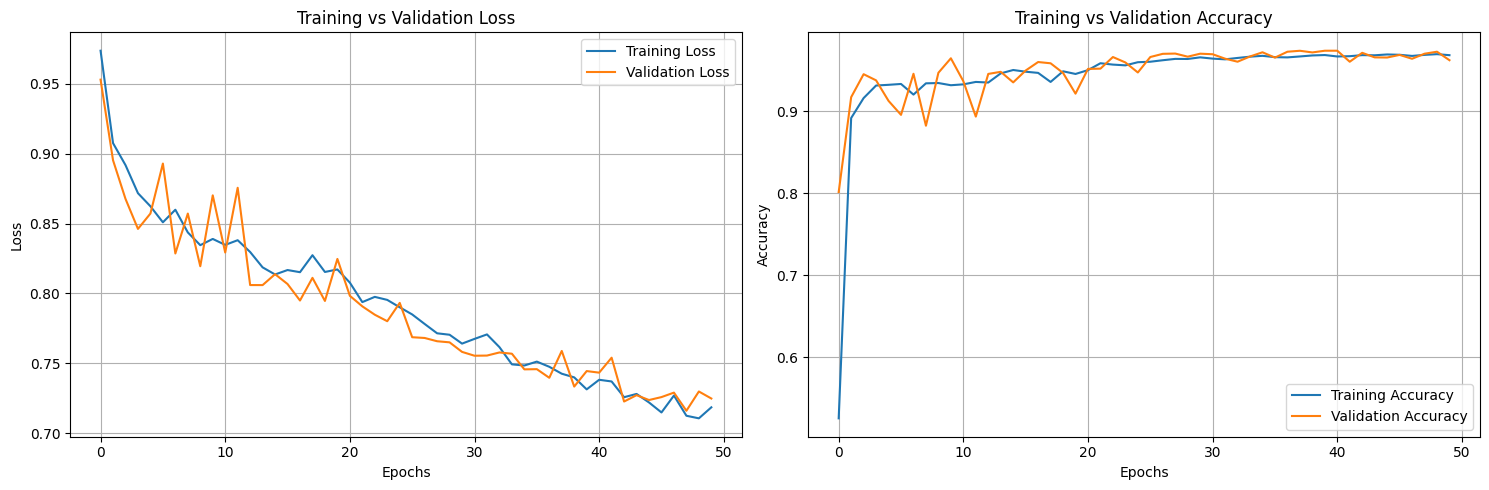

In [ ]:
plotHist(diceHistory)

### Evaluate Performance

We generate predictions using the best performing model in order to calculate the evaluation metrics.

In [ ]:
YValPredDice = diceModel.predict(XVal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


We generate the DICE score and macro metrics tables for this round and concatenate them with the tables from the previous round to build our tally. The DICE loss has significantly improved the model's performance. The DICE score for the edema class significantly improved from 0.26 to 0.4, similarly the DICE score for the enhancing tumour increased from 0.13 to 0.23. This is about an 80% increase in the DICE scores.

### Dice Table

In [ ]:
diceTable = diceScore(YValCat, YValPredDice, modelName="Dice Loss")

In [ ]:
DICEtally = pd.concat([baseTable, diceTable])

In [ ]:
DICEtally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
Base Model,0.1768,0.1429,0.2604,0.1270
Dice Loss,0.3026,0.2802,0.4039,0.2237


### Classification Metrics

In [ ]:
diceMetrics = classMets(YValCat, YValPredDice, modelName="Dice Loss")

In [ ]:
METtally = pd.concat([baseMetrics, diceMetrics])

In [ ]:
METtally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
Base Model,0.6318,0.1361,0.1684,0.2224
Dice Loss,0.5448,0.2926,0.3761,0.3528


---
---
# Simple CNN with Combined Loss
---

In this round we create another custom loss function, except this time

---
## Define & Compile Model
---

### Define Combined Loss Function

The combined loss function calculates both the DICE Loss as it was calculated in the previous round and Tensorflow's default categorical cross-entropy loss and returns their weighted average. The loss weights are controlled by a parameter, alpha, which is set in the compiler. The formula for weight control is:

$$
\text{Combined Loss} = \alpha \cdot \text{DiceLoss} + (1 - \alpha) \cdot \text{CrossEntropyLoss}
$$

Where the strength of alpha, $\alpha$, controlls how much weight is given to the DICE loss and 1 - $\alpha$ is the weight given to the cross-entropy loss.

In [ ]:
def combinedLoss(yTrue, yPred, alpha=0.5, smooth=1e-6):
    yTrueFlat = K.reshape(yTrue, (-1, 4))
    yPredFlat = K.reshape(yPred, (-1, 4))

    diceLossValue = 0
    for c in range(1, 4):
        yt = yTrueFlat[:, c]
        yp = yPredFlat[:, c]
        intersection = K.sum(yt * yp)
        union = K.sum(yt) + K.sum(yp)
        dice = (2. * intersection + smooth) / (union + smooth)
        diceLossValue += 1 - dice
    diceLossValue /= 3
    ceLossValue = tf.keras.losses.categorical_crossentropy(yTrue, yPred)

    return alpha * diceLossValue + (1 - alpha) * tf.reduce_mean(ceLossValue)

### Compile Combined Loss Model

We compile the model by passing the combined loss function within an anonymous lambda function to the model. This allows us to specify the alpha value which is set to 0.5 to give both loss functions an equal weighting.

In [ ]:
combModel = baseCNN()

In [ ]:
combModel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda yTrue, yPred: combinedLoss(yTrue, yPred, alpha=0.5),
    metrics=["accuracy"])

---
## Train
---

We fit the model with the standard training parameters for Phase 1.

In [ ]:
combHistory = combModel.fit(x=XTrain,y=YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[earlyStopping, checkpoint],
    verbose=0)

---
## Evaluate
---

While the training appears unstable with the combined loss, the inverse is in fact true as the axis on the accuracy plot covers a range of 0.02. This is further demonstrated in the next round. The model learns at a faster rate than the previous round and shows a steady decline, showing clear signs of underfitting.

### Plot Training History

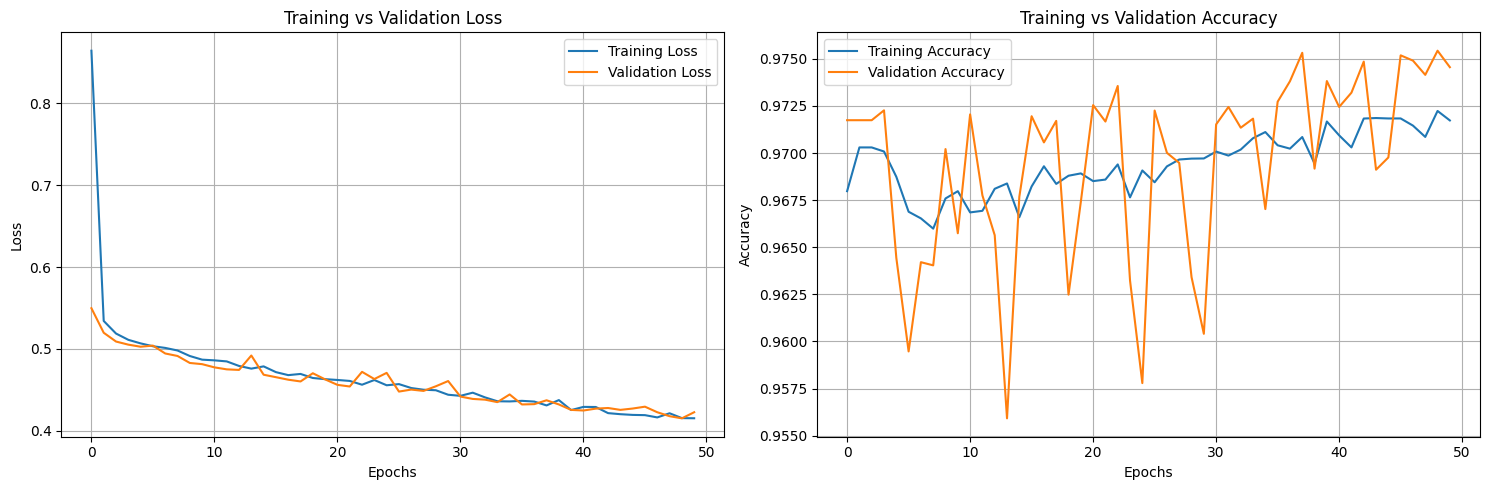

In [ ]:
plotHist(combHistory)

### Make Predictions, Calculate DICE and Metrics Tables

We make predictions using the best model, generate the metrics tables and concatenate the results.

In [ ]:
YValPredCombo = combModel.predict(XVal)

combDICE = diceScore(YValCat, YValPredCombo, modelName="Combined Loss")
combMetrics = classMets(YValCat, YValPredCombo, modelName="Combined Loss")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


### Display Tallies

In [ ]:
DICEtally = pd.concat([DICEtally, combDICE])
METtally = pd.concat([METtally, combMetrics])

The combined loss has performed second best behind the pure DICE loss with a mean DICE score of 0.28 and a macro F1 score of 0.35. Based on these results the pure DICE score appears to perform best across most metrics.

In [ ]:
DICEtally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
Base Model,0.1768,0.1429,0.2604,0.1270
Dice Loss,0.3026,0.2802,0.4039,0.2237
Combined Loss,0.2825,0.2816,0.3348,0.2312


In [ ]:
METtally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
Base Model,0.6318,0.1361,0.1684,0.2224
Dice Loss,0.5448,0.2926,0.3761,0.3528
Combined Loss,0.5640,0.2561,0.3519,0.2809


---
---
# Weighted DICE Loss
---

---
## Build & Compile
---

Although DICE loss outperformed the combined loss, the DICE loss does not account for the backgroound. This can encourage the model to overestimate the masks. In order to prevent mask bleed, we include a small penalty term which will penalise the model when it makes the mask too large. To do this, we use a combined loss where the DICE score is given a 0.9 weighting and the cross-entrophy loss is given a weighting of 0.1. We do this by setting alpha to 0.9.

In [ ]:
combWeighted = baseCNN()

combWeighted.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda yTrue, yPred: combinedLoss(yTrue, yPred, alpha=0.9),
    metrics=["accuracy"])

---
### Train
---

We establish new model checkpoints for this round and fit the model for 50 epochs and a batch size of 16.

In [ ]:
checkpointPath_combWeighted = os.path.join(saveDir, "combWeighted_best.weights.h5")

checkpoint_combWeighted = ModelCheckpoint(filepath=checkpointPath_combWeighted,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStopping_combWeighted = EarlyStopping(monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=0)

In [ ]:
history_combWeighted = combWeighted.fit(x=XTrain,
    y=YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint_combWeighted, earlyStopping_combWeighted],
    verbose=0)

---
### Evaluate
---

The loss decreases steadily before showing slight signs of overfitting.

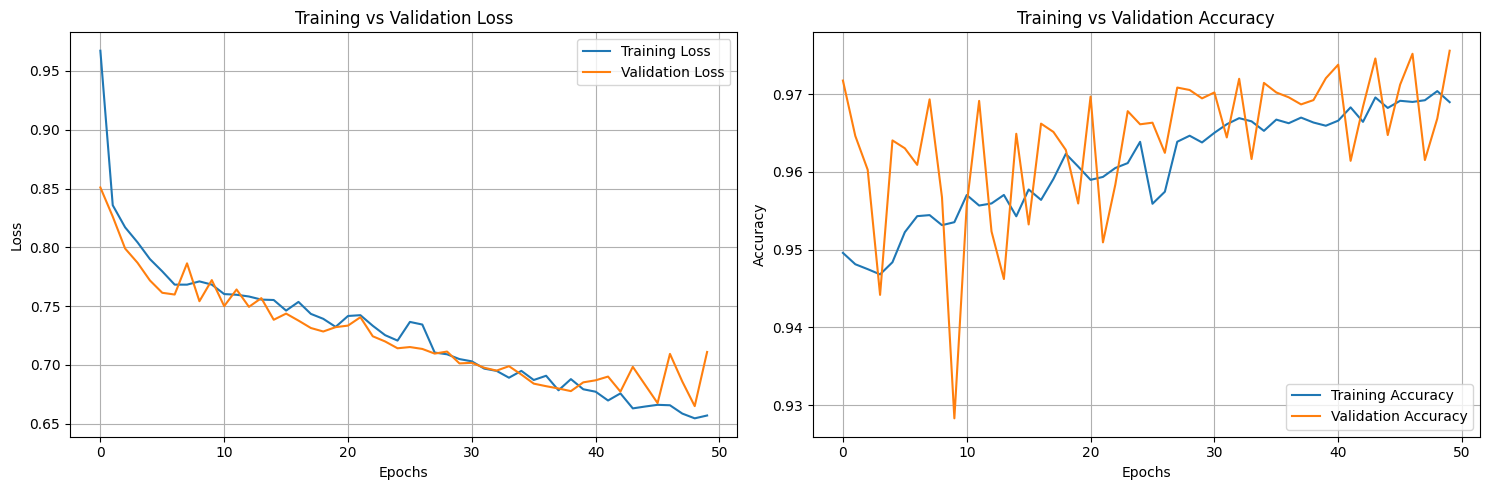

In [ ]:
plotHist(history_combWeighted)

The training is not as unstable as the accuracy logs make it appear. The instability is happening within a 5% accuracy range. This can be better understood by visualising the graph with the y-axis on a scale of 0 to 1. As we can see, the training log is nearly flat, and the overall validation accuracy is nearly 100%.

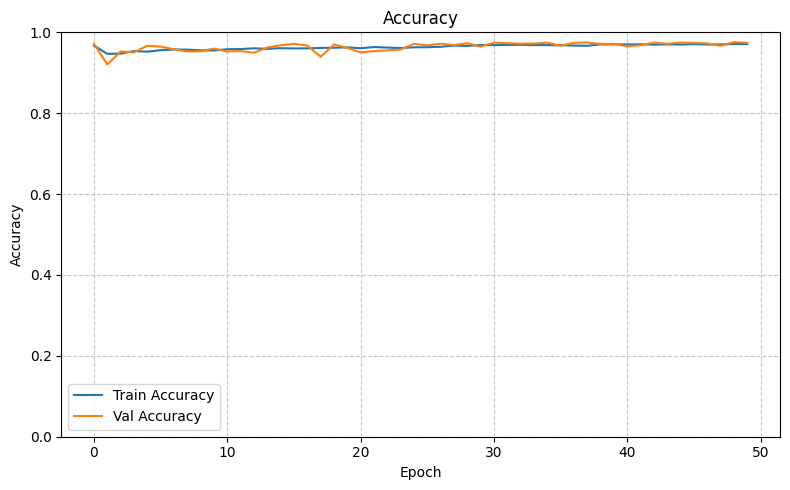

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_combWeighted.history["accuracy"], label="Train Accuracy")
plt.plot(history_combWeighted.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # 👈 normal 0 to 1 scale
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

We generate predictions using the restored model and generate the metric tables.

In [ ]:
YValPred_combWeighted = combWeighted.predict(XVal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


In [ ]:
DICE_combWeighted = diceScore(YValCat, YValPred_combWeighted,
    modelName="Combined Weighted")

In [ ]:
metrics_combWeighted = classMets(YValCat, YValPred_combWeighted,
    modelName="Combined Weighted")

In [ ]:
DICEtally = pd.concat([DICEtally, DICE_combWeighted])
METtally = pd.concat([METtally, metrics_combWeighted])

**Metrics Interpretations**

The DICE loss with the penalty term has performed best across most metrics. It achieved an average DICE score of 0.32, a macro average of 0.39 and an accuracy for the tumour regions of 0.33. While we have been able to see a clear trend in the data regarding which loss function is best for the model, there is clear room for improvement, which will be explored in Phase 2.

In [ ]:
display(DICEtally)
display(METtally)

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
Base Model,0.1768,0.1429,0.2604,0.1270
Dice Loss,0.3026,0.2802,0.4039,0.2237
Combined Loss,0.2825,0.2816,0.3348,0.2312
Combined Weighted,0.3213,0.2851,0.4052,0.2737


,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
Base Model,0.6318,0.1361,0.1684,0.2224
Dice Loss,0.5448,0.2926,0.3761,0.3528
Combined Loss,0.5640,0.2561,0.3519,0.2809
Combined Weighted,0.5731,0.2928,0.3855,0.3284


### Plot the Results

We visualise the results of the above tally in side by side bar charts. The plots clearly show that the weighted loss has performed best.

In [ ]:
metricsMeltedDice = DICEtally.reset_index().melt(
    id_vars="index",
    value_vars=["Mean", "1 Necrotic Core", "2 Edema", "3 Enhancing Tumour"],
    var_name="Metric",
    value_name="Score").rename(columns={"index": "Model"})

metricsMeltedPRA = METtally.reset_index().melt(
    id_vars="index",
    value_vars=["Macro Precision", "Macro Recall", "Macro F1", "Accuracy (No Background)"],
    var_name="Metric",
    value_name="Score").rename(columns={"index": "Model"})

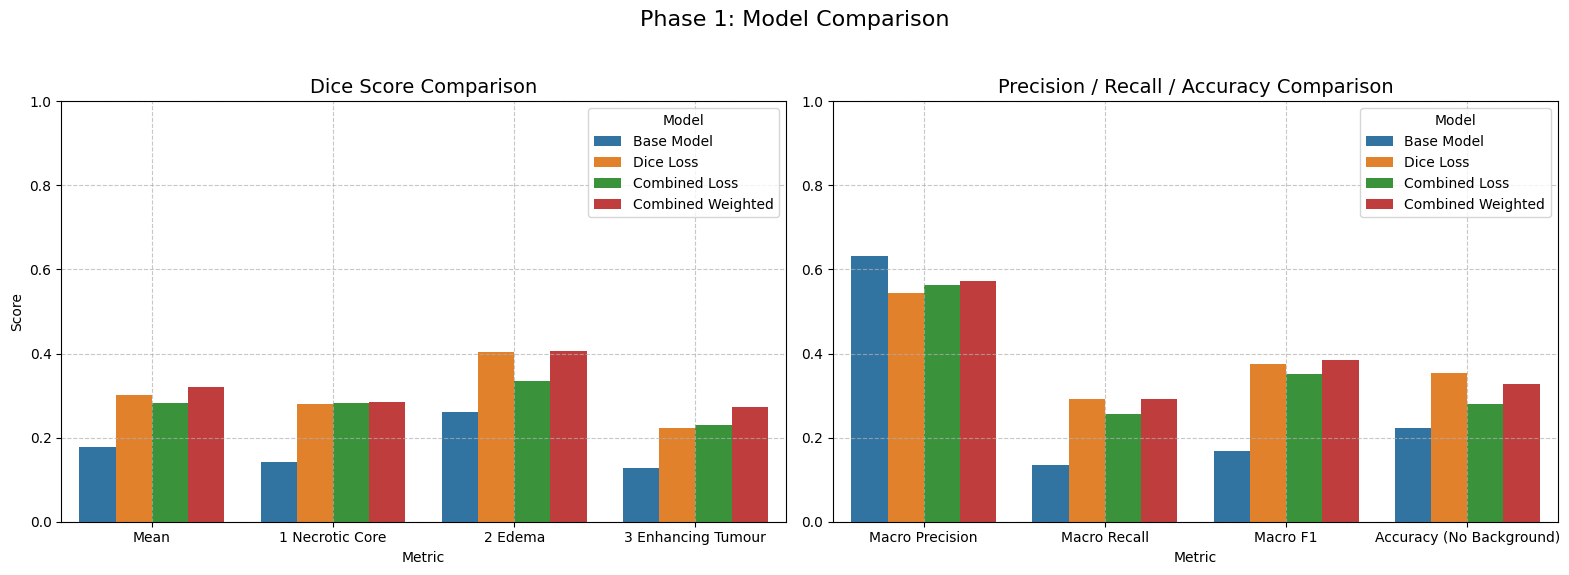

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=metricsMeltedDice, x="Metric", y="Score", hue="Model", ax=axs[0])
axs[0].set_title("Dice Score Comparison", fontsize=14)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Score")
axs[0].grid(True, linestyle='--', alpha=0.7)

sns.barplot(data=metricsMeltedPRA, x="Metric", y="Score", hue="Model", ax=axs[1])
axs[1].set_title("Precision / Recall / Accuracy Comparison", fontsize=14)
axs[1].set_ylim(0, 1)
axs[1].set_ylabel("")
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.suptitle("Phase 1: Model Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

---
---
# Conclusion
---

In this phase we have compared four loss functions, the categorical cross-entropy loss, DICE loss, combined loss and the DICE loss with a penalty term. Each model was built using the same baseline CNN architecture and model parameters. The DICE loss with the penalty term has performed best across all metrics except for macro precision which had an inverse relationship with the other metrics. In the next section, Phase 2, we test different model architectures to build upon the model's performance.

---
---